# "Parts of form" explorer

developed by Kow Kuroda (kow.kuroda@gmail.com)

History

Created 2024/09/13

Modified 2025/08/01 i) added handling of Englsh WN3 word classification; ii) added gender sub-classification for Irish;

In [80]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [81]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [82]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [83]:
## install Cython if necessary
#!conda install Cython -y

In [84]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [85]:
## Cython を使うかどうか
use_Cython = True
if use_Cython:
    %load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [86]:
## doc settings
doc_types        = [ 'spell', 'sound' ]
doc_type          = doc_types[0]
print(f"doc_type: {doc_type}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"
print(f"mark_boundaries with {boundary_mark}: {doc_type}")

## sizes
max_doc_size        = 11
min_doc_size        =  5
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

doc_type: spell
mark_boundaries with #: spell
max_doc_size: 11
min_doc_size: 5


In [87]:
## term settings
ngram_is_inclusive  = True
inclusion_degree    = None # or 1 # smaller values give better results

## term setting
#ngram_is_skippy       = False
skippy_means_extended = False

gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if doc_type == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

accent_status: 


In [88]:
## select target files
import glob
data_dir1      = "data/open-dict-ipa/data1"
data_dir2      = "data/open-dict-ipa/data1a"
data_dir3      = "data/wn3"
data_dir4      = "data/irish"
target_files   = glob.glob(f"{data_dir1}/*")
target_files2  = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3  = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4  = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
pp.pprint(target_files)

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ro.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_

In [89]:
## key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German noun',
                        'de_non_N_only' : 'German non-noun',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nb'    : 'Norwegian',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nb', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]

In [90]:
## select language
target_lang_key  = target_lang_keys[-1]
print(f"target_lang_key: {target_lang_key}")
target_lang_name = target_lang_dict[target_lang_key]
print(f"target lang: {target_lang_name} [{target_lang_key}]")

target_lang_key: ir
target lang: Irish [ir]


In [91]:
## select word class
selects_word_class = True

# R_only is not available for Irish, non_N_only for German;
target_word_classes = [ 'N_only', 'non_N_only', 'A_only', 'R_only', 'V_only' ]
if not selects_word_class:
    target_word_class = None
else:
    #target_word_class = target_word_classes[0:1] + target_word_classes[-1:]
    target_word_class = target_word_classes[0]
print(f"target_word_class: {target_word_class}")
#
target_files_base = target_files.copy() # make a reserve
#
if selects_word_class:
    lang_key = target_lang_key.split("_")[0]
    print(f"lang_key: {lang_key}")
    print(f"target_word_class: {target_word_class}")
    if not target_word_class != 'non_N_only':
        target_files = [ f for f in target_files_base if not f"non_{target_word_class}" in f ]
    if type(target_word_class) == 'list':
        target_files = [ f for f in target_files if any(wc in f for wc in target_word_class) and lang_key in f ]
    else:
        target_files = [ f for f in target_files if target_word_class in f and lang_key in f ]
##
pp.pprint(target_files)

target_word_class: N_only
lang_key: ir
target_word_class: N_only
['data/irish/irish-spell-N_only.csv']


In [92]:
## get source data from files
import pandas as pd
import gzip

for target_file in target_files:
    print(f"processing: {target_file}")
    if target_lang_key == "ir":
        col_names = ['spell', 'POS']
    else:
        col_names = ['spell', 'sound']

    ##
    if target_file.endswith(".gz"):
        with gzip.open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
    else:
        with open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

    ## normalize characters
    raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

    ## modify sound
    try:
        sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
        sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
        raw_df['sound'] = sounds
    except (AttributeError, KeyError):
        pass
    #
raw_df.sample(30)

processing: data/irish/irish-spell-N_only.csv


,spell,POS
13755,geantraí,fem1
24124,saighdeadh,masc0
8903,deifir,fem2
11928,Fionlannach,masc0
4636,caomheagar,masc0
1705,athiontráil,fem1
11657,feitheoir,masc3
15045,grugaill,fem1
408,ailléil,fem1
16450,irischlár,masc1


In [100]:
## select gender
selects_gender = True

target_genders = [ 'fem', 'masc', 'neu' ] # neuter is effective for German only
target_gender = target_genders[0]
print(f"target_gender: {target_gender}")

## make a reserve
try:
    raw_df_origin
except NameError:
    raw_df_origin = raw_df.copy()
##
if target_lang_key in [ 'ir' ] and target_word_class in ['N_only'] and selects_gender:
    raw_df = raw_df_origin[raw_df_origin['POS'].apply(lambda x: x[:len(x)-1]) == target_gender]
else:
    target_gender = None
#
raw_df

target_gender: fem


,spell,POS
3,abacht,fem1
4,abairt,fem2
5,ábaltacht,fem3
7,abarlach,fem1
8,abarthacht,fem3
...,...,...
30694,y-chomhordanáid,fem2
30696,zéite,fem4
30698,zó-eolaíocht,fem3
30699,zóifít,fem1


In [101]:
## source sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 3000
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		source_sampling_n = source_sampling_max_size
	else:
		source_sampling_n = round(len(raw_df) * source_sampling_rate)
	raw_df = raw_df.sample(source_sampling_n)
else:
	source_sampling_n = None

## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                    spell   POS
19548    #míoladóireacht#  fem1
7328          #cothroime#  fem4
21189            #óirthí#  fem1
1026             #anairí#  fem1
29331        #tonnuimhir#  fem1
...                   ...   ...
24865       #sciobthacht#  fem1
2911             #bocáil#  fem3
20615  #neamhfhreagracht#  fem1
11855     #Filistíneacht#  fem1
8103           #cuinneog#  fem2

[3000 rows x 2 columns]


In [102]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,POS,sp_1gram,sp_size,hyphen,period
19548,#míoladóireacht#,fem1,"[#, m, í, o, l, a, d, ó, i, r, e, a, c, h, t, #]",16,0,0
7328,#cothroime#,fem4,"[#, c, o, t, h, r, o, i, m, e, #]",11,0,0
21189,#óirthí#,fem1,"[#, ó, i, r, t, h, í, #]",8,0,0
1026,#anairí#,fem1,"[#, a, n, a, i, r, í, #]",8,0,0
29331,#tonnuimhir#,fem1,"[#, t, o, n, n, u, i, m, h, i, r, #]",12,0,0
...,...,...,...,...,...,...
24865,#sciobthacht#,fem1,"[#, s, c, i, o, b, t, h, a, c, h, t, #]",13,0,0
2911,#bocáil#,fem3,"[#, b, o, c, á, i, l, #]",8,0,0
20615,#neamhfhreagracht#,fem1,"[#, n, e, a, m, h, f, h, r, e, a, g, r, a, c, ...",18,0,0
11855,#Filistíneacht#,fem1,"[#, F, i, l, i, s, t, í, n, e, a, c, h, t, #]",15,0,0


In [103]:
## filtering raw_data by size
print(f"term_class: {doc_type}")
if "spell" == doc_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_class: spell


,spell,POS,sp_1gram,sp_size,hyphen,period
7328,#cothroime#,fem4,"[#, c, o, t, h, r, o, i, m, e, #]",11,0,0
21189,#óirthí#,fem1,"[#, ó, i, r, t, h, í, #]",8,0,0
1026,#anairí#,fem1,"[#, a, n, a, i, r, í, #]",8,0,0
3780,#buantonn#,fem2,"[#, b, u, a, n, t, o, n, n, #]",10,0,0
11092,#fadaraí#,fem1,"[#, f, a, d, a, r, a, í, #]",9,0,0
...,...,...,...,...,...,...
28984,#tiomáint#,fem3,"[#, t, i, o, m, á, i, n, t, #]",10,0,0
23943,#rúbóg#,fem1,"[#, r, ú, b, ó, g, #]",7,0,0
12648,#fortacht#,fem3,"[#, f, o, r, t, a, c, h, t, #]",10,0,0
2911,#bocáil#,fem3,"[#, b, o, c, á, i, l, #]",8,0,0


In [104]:
## second sampling if needed
second_sampling          = False
second_sampling_rate     = 0.7
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

1656

# Functions

In [105]:
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}sk{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}sk{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

In [106]:
def get_terms_by_freq_rank(dfx, rank_range: tuple, prefix: str = "", n_for_ngram: int = 2, skippy: bool = False, gap_mark: str = "…", check = False):
    "return list of most N frequent terms"
    import collections
    ## define variables
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = "" 
    var_name = f'{prefix}{skippiness}{n_for_ngram}gram'
    if check:
        print(f"var_name: {var_name}")
    ## main
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_for_ngram]) for L in dfx[var_name] ]
    if check:
        print(G)
    ## filtering data
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if check:
        print(f"highest_rank: {highest_rank}; lowest_rank: {lowest_rank}")
    R = collections.Counter(G).most_common(lowest_rank)
    R = R[(highest_rank - 1):]
    if check:
        print(R)
    ## return
    return R

In [107]:
def show_terms_with_ranking(ranking, rank_range: tuple, n_for_ngram: int, skippy: bool, prefix: str = "", lang: str = target_lang_name, word_class: str = target_word_class, gender: str = target_gender, check = False):
    "display terms with a given frequency rank range"
    ## imports
    import matplotlib.pyplot as plt
    ## variables
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = ""
    target_var_name = f"{prefix}{skippiness}{n_for_ngram}g"

    ## get freq data
    ranking = sorted(ranking, key = lambda x: x[1], reverse = False)
    terms, freqs = [ ], [ ]
    for x in ranking:
        term, freq = x[0], x[1]
        if len(term) > 0 and freq > 0:
            terms.append(term)
            freqs.append(freq)

    ## plot
    plt.figure(figsize = (6, 0.25 * len(terms)))
    plt.autoscale(enable = True, axis = 'y', tight = True)
    plt.barh(terms, freqs)
    if gender is None:
        title_val = f"Freq-ranked distribution [rank {highest_rank} – rank {lowest_rank}] of {target_var_name} from\n{lang} (sample {source_sampling_n} from word_class: {word_class}) "
    else:
        title_val = f"Freq-ranked distribution [rank {highest_rank} - rank {lowest_rank}] of {target_var_name} from\n{lang} (sample {source_sampling_n} from word_class: {word_class} with gender: {gender}) "
    plt.title(title_val)
    plt.plot()

# Main

In [108]:
# frequency rank range for terms to show
highest_freq_rank_for_terms_to_show = 1
lowest_freq_rank_for_terms_to_show  = 100
rank_range  = (highest_freq_rank_for_terms_to_show, lowest_freq_rank_for_terms_to_show)
print(f"rank_range: {rank_range}")

rank_range: (1, 100)


## Spell

### Non-skippy spell

In [109]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
7328     [#c, co, ot, th, hr, ro, oi, im, me, e#, #, c,...
21189    [#ó, ói, ir, rt, th, hí, í#, #, ó, i, r, t, h,...
1026     [#a, an, na, ai, ir, rí, í#, #, a, n, a, i, r,...
3780     [#b, bu, ua, an, nt, to, on, nn, n#, #, b, u, ...
11092    [#f, fa, ad, da, ar, ra, aí, í#, #, f, a, d, a...
                               ...                        
28984    [#t, ti, io, om, má, ái, in, nt, t#, #, t, i, ...
23943        [#r, rú, úb, bó, óg, g#, #, r, ú, b, ó, g, #]
12648    [#f, fo, or, rt, ta, ac, ch, ht, t#, #, f, o, ...
2911     [#b, bo, oc, cá, ái, il, l#, #, b, o, c, á, i,...
8103     [#c, cu, ui, in, nn, ne, eo, og, g#, #, c, u, ...
Name: sp_2gram, Length: 1656, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


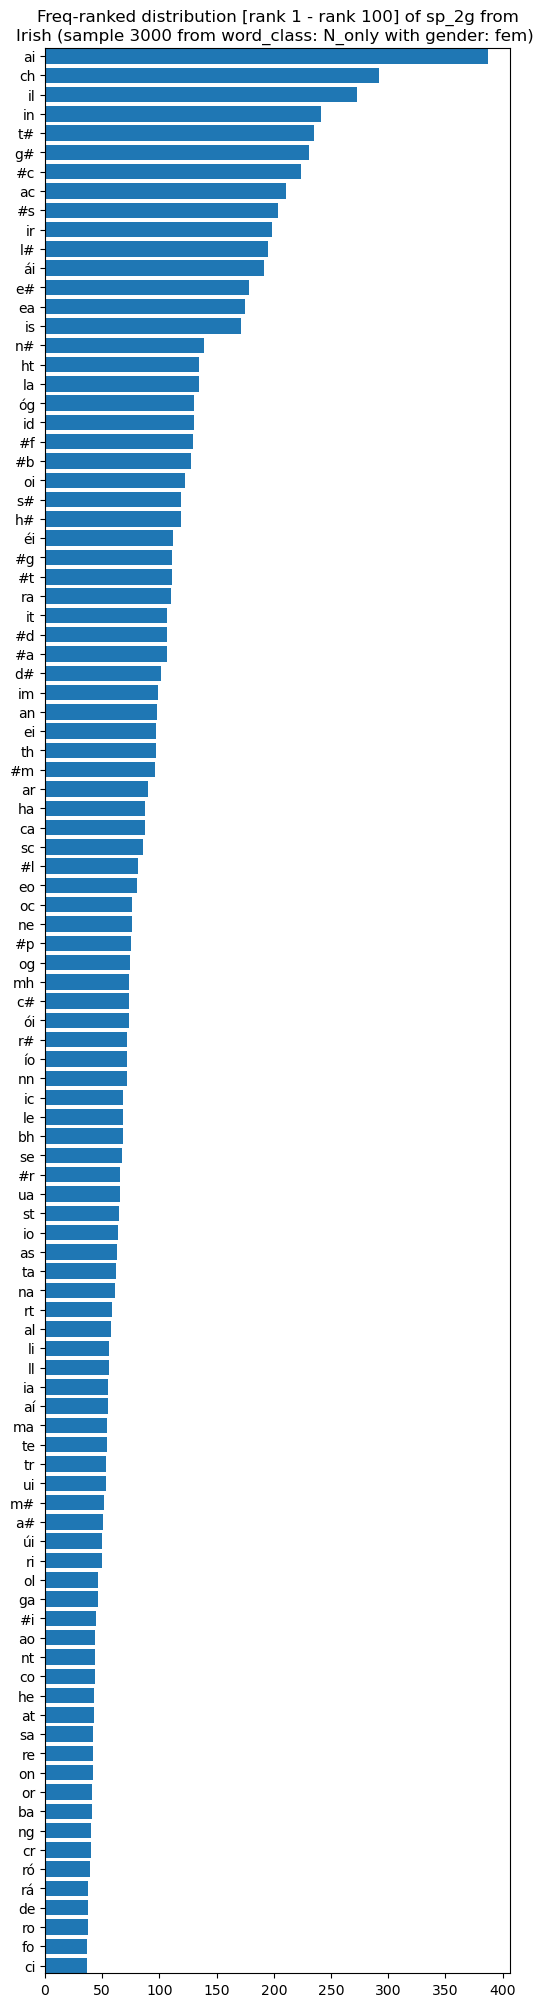

In [110]:
## frequency-ranked view
skippy = False
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [111]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
7328     [#co, cot, oth, thr, hro, roi, oim, ime, me#, ...
21189    [#ói, óir, irt, rth, thí, hí#, #ó, ói, ir, rt,...
1026     [#an, ana, nai, air, irí, rí#, #a, an, na, ai,...
3780     [#bu, bua, uan, ant, nto, ton, onn, nn#, #b, b...
11092    [#fa, fad, ada, dar, ara, raí, aí#, #f, fa, ad...
                               ...                        
28984    [#ti, tio, iom, omá, mái, áin, int, nt#, #t, t...
23943    [#rú, rúb, úbó, bóg, óg#, #r, rú, úb, bó, óg, ...
12648    [#fo, for, ort, rta, tac, ach, cht, ht#, #f, f...
2911     [#bo, boc, ocá, cái, áil, il#, #b, bo, oc, cá,...
8103     [#cu, cui, uin, inn, nne, neo, eog, og#, #c, c...
Name: sp_3gram, Length: 1656, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


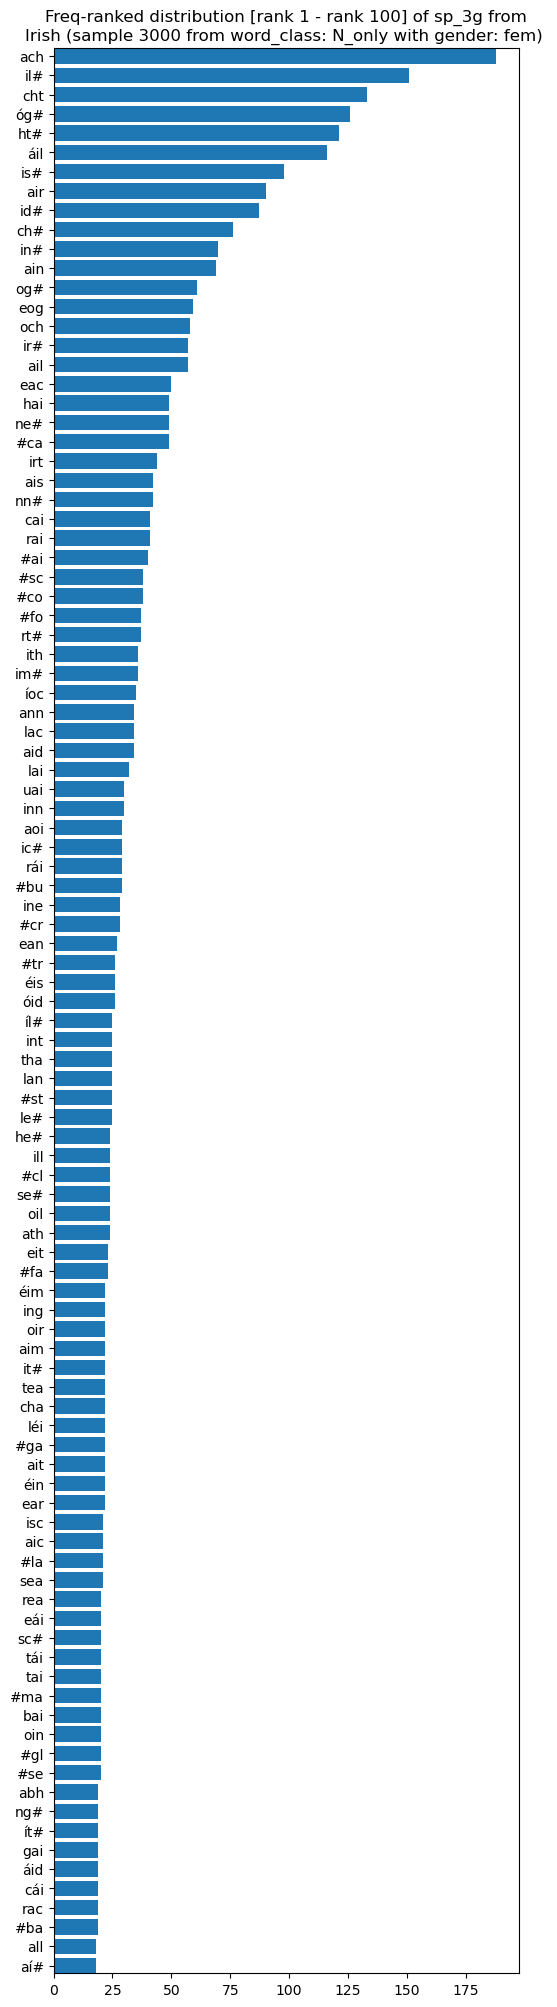

In [112]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [113]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
7328     [#cot, coth, othr, thro, hroi, roim, oime, ime...
21189    [#óir, óirt, irth, rthí, thí#, #ói, óir, irt, ...
1026     [#ana, anai, nair, airí, irí#, #an, ana, nai, ...
3780     [#bua, buan, uant, anto, nton, tonn, onn#, #bu...
11092    [#fad, fada, adar, dara, araí, raí#, #fa, fad,...
                               ...                        
28984    [#tio, tiom, iomá, omái, máin, áint, int#, #ti...
23943    [#rúb, rúbó, úbóg, bóg#, #rú, rúb, úbó, bóg, ó...
12648    [#for, fort, orta, rtac, tach, acht, cht#, #fo...
2911     [#boc, bocá, ocái, cáil, áil#, #bo, boc, ocá, ...
8103     [#cui, cuin, uinn, inne, nneo, neog, eog#, #cu...
Name: sp_4gram, Length: 1656, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


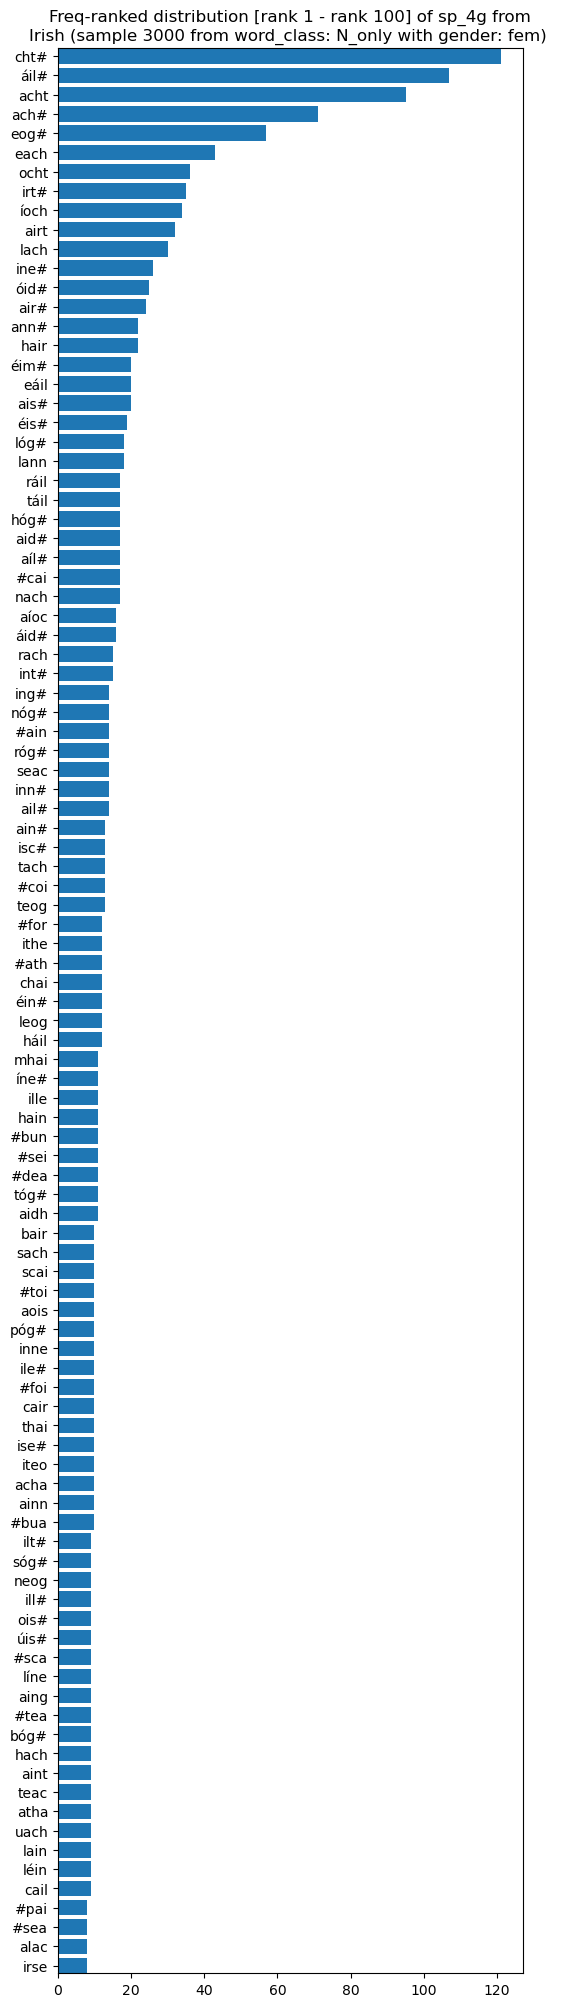

In [114]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [115]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
7328     [#coth, cothr, othro, throi, hroim, roime, oim...
21189    [#óirt, óirth, irthí, rthí#, #óir, óirt, irth,...
1026     [#anai, anair, nairí, airí#, #ana, anai, nair,...
3780     [#buan, buant, uanto, anton, ntonn, tonn#, #bu...
11092    [#fada, fadar, adara, daraí, araí#, #fad, fada...
                               ...                        
28984    [#tiom, tiomá, iomái, omáin, máint, áint#, #ti...
23943    [#rúbó, rúbóg, úbóg#, #rúb, rúbó, úbóg, bóg#, ...
12648    [#fort, forta, ortac, rtach, tacht, acht#, #fo...
2911     [#bocá, bocái, ocáil, cáil#, #boc, bocá, ocái,...
8103     [#cuin, cuinn, uinne, inneo, nneog, neog#, #cu...
Name: sp_5gram, Length: 1656, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


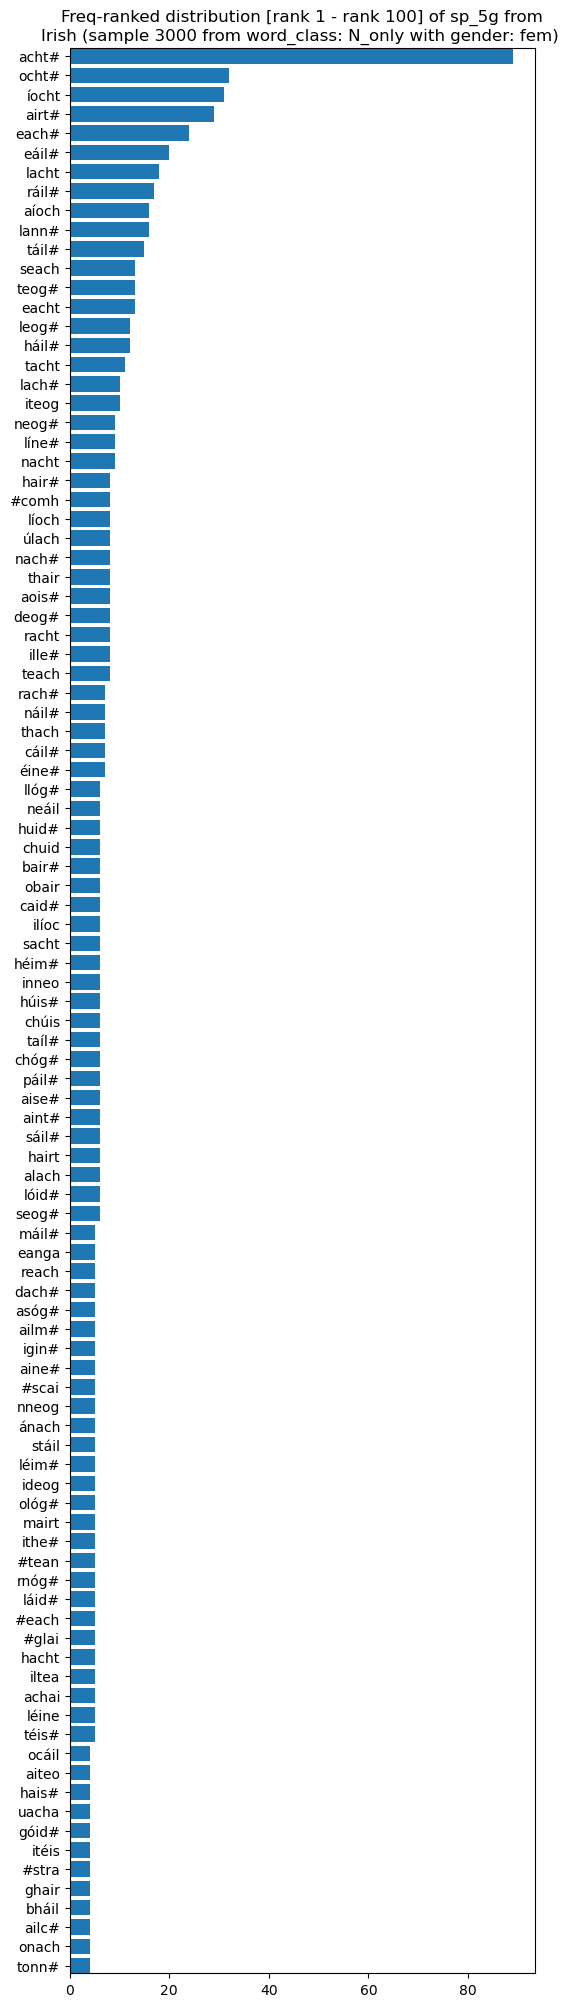

In [116]:
## frequency-rank view
skippy = False
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy spell

In [117]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk2gram
min_size: 1
supplement_var: sp_1gram
7328     [#c, #…o, #…t, #…h, #…r, #…o, #…i, #…m, #…e, #...
21189    [#ó, #…i, #…r, #…t, #…h, #…í, #…#, ói, ó…r, ó…...
1026     [#a, #…n, #…a, #…i, #…r, #…í, #…#, an, a…a, a…...
3780     [#b, #…u, #…a, #…n, #…t, #…o, #…n, #…n, #…#, b...
11092    [#f, #…a, #…d, #…a, #…r, #…a, #…í, #…#, fa, f…...
                               ...                        
28984    [#t, #…i, #…o, #…m, #…á, #…i, #…n, #…t, #…#, t...
23943    [#r, #…ú, #…b, #…ó, #…g, #…#, rú, r…b, r…ó, r…...
12648    [#f, #…o, #…r, #…t, #…a, #…c, #…h, #…t, #…#, f...
2911     [#b, #…o, #…c, #…á, #…i, #…l, #…#, bo, b…c, b…...
8103     [#c, #…u, #…i, #…n, #…n, #…e, #…o, #…g, #…#, c...
Name: sp_sk2gram, Length: 1656, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


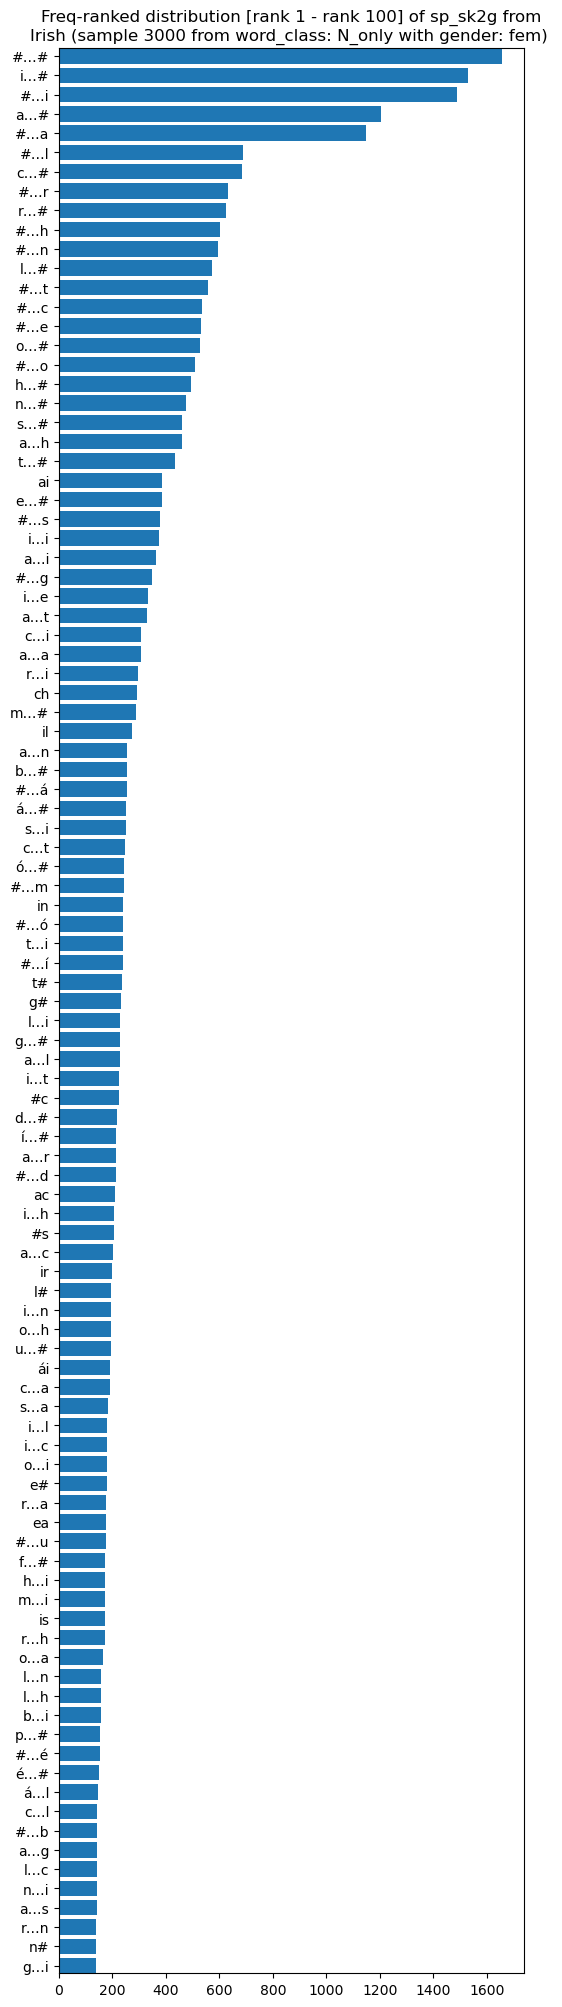

In [118]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [119]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk3gram
min_size: 1
supplement_var: sp_sk2gram
7328     [#co, #c…t, #c…h, #c…r, #c…o, #c…i, #c…m, #c…e...
21189    [#ói, #ó…r, #ó…t, #ó…h, #ó…í, #ó…#, #…ir, #…i…...
1026     [#an, #a…a, #a…i, #a…r, #a…í, #a…#, #…na, #…n…...
3780     [#bu, #b…a, #b…n, #b…t, #b…o, #b…n, #b…n, #b…#...
11092    [#fa, #f…d, #f…a, #f…r, #f…a, #f…í, #f…#, #…ad...
                               ...                        
28984    [#ti, #t…o, #t…m, #t…á, #t…i, #t…n, #t…t, #t…#...
23943    [#rú, #r…b, #r…ó, #r…g, #r…#, #…úb, #…ú…ó, #…ú...
12648    [#fo, #f…r, #f…t, #f…a, #f…c, #f…h, #f…t, #f…#...
2911     [#bo, #b…c, #b…á, #b…i, #b…l, #b…#, #…oc, #…o…...
8103     [#cu, #c…i, #c…n, #c…n, #c…e, #c…o, #c…g, #c…#...
Name: sp_sk3gram, Length: 1656, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


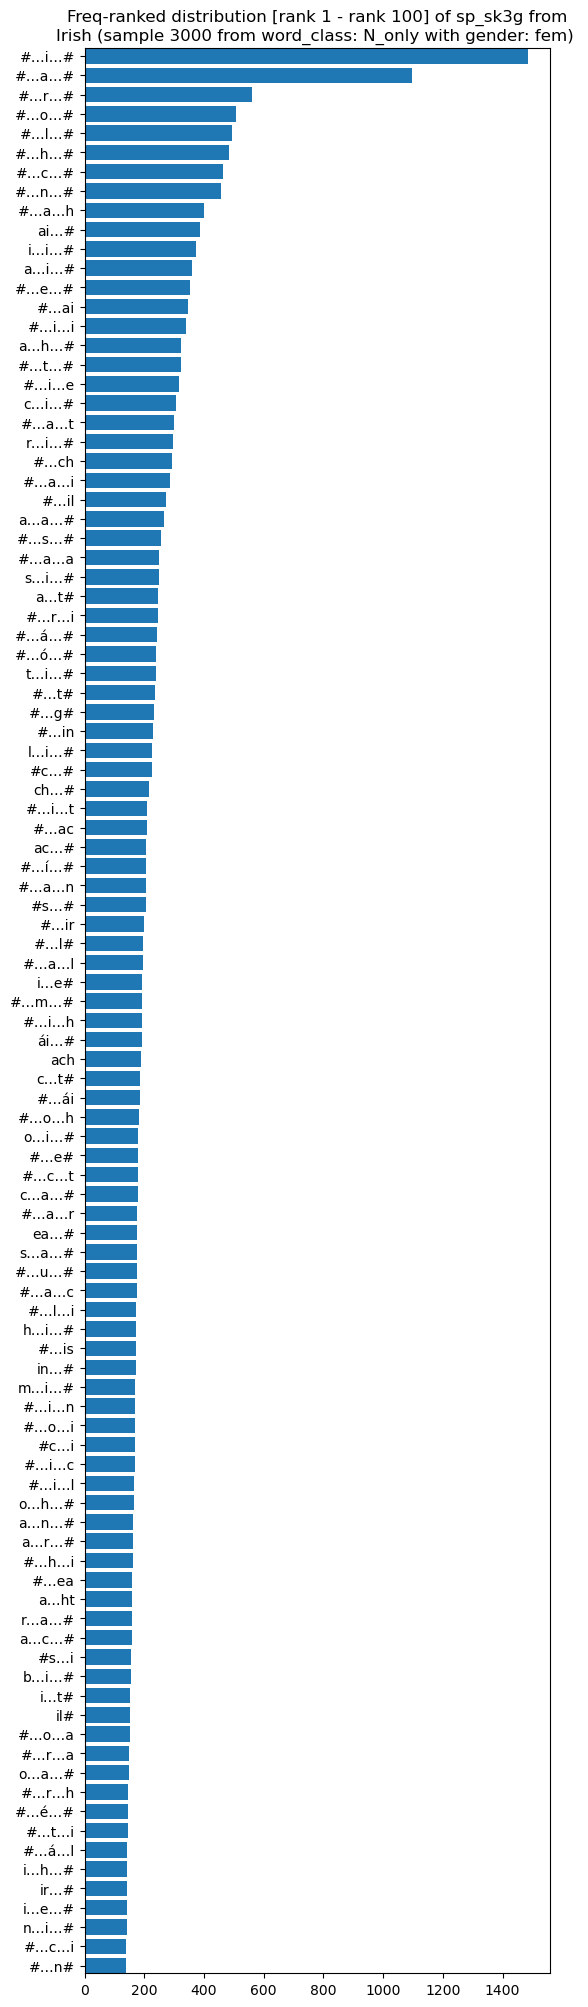

In [120]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [121]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk4gram
min_size: 1
supplement_var: sp_sk3gram
7328     [#cot, #co…h, #co…r, #co…o, #co…i, #co…m, #co…...
21189    [#óir, #ói…t, #ói…h, #ói…í, #ói…#, #ó…rt, #ó…r...
1026     [#ana, #an…i, #an…r, #an…í, #an…#, #a…ai, #a…a...
3780     [#bua, #bu…n, #bu…t, #bu…o, #bu…n, #bu…n, #bu…...
11092    [#fad, #fa…a, #fa…r, #fa…a, #fa…í, #fa…#, #f…d...
                               ...                        
28984    [#tio, #ti…m, #ti…á, #ti…i, #ti…n, #ti…t, #ti…...
23943    [#rúb, #rú…ó, #rú…g, #rú…#, #r…bó, #r…b…g, #r…...
12648    [#for, #fo…t, #fo…a, #fo…c, #fo…h, #fo…t, #fo…...
2911     [#boc, #bo…á, #bo…i, #bo…l, #bo…#, #b…cá, #b…c...
8103     [#cui, #cu…n, #cu…n, #cu…e, #cu…o, #cu…g, #cu…...
Name: sp_sk4gram, Length: 1656, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


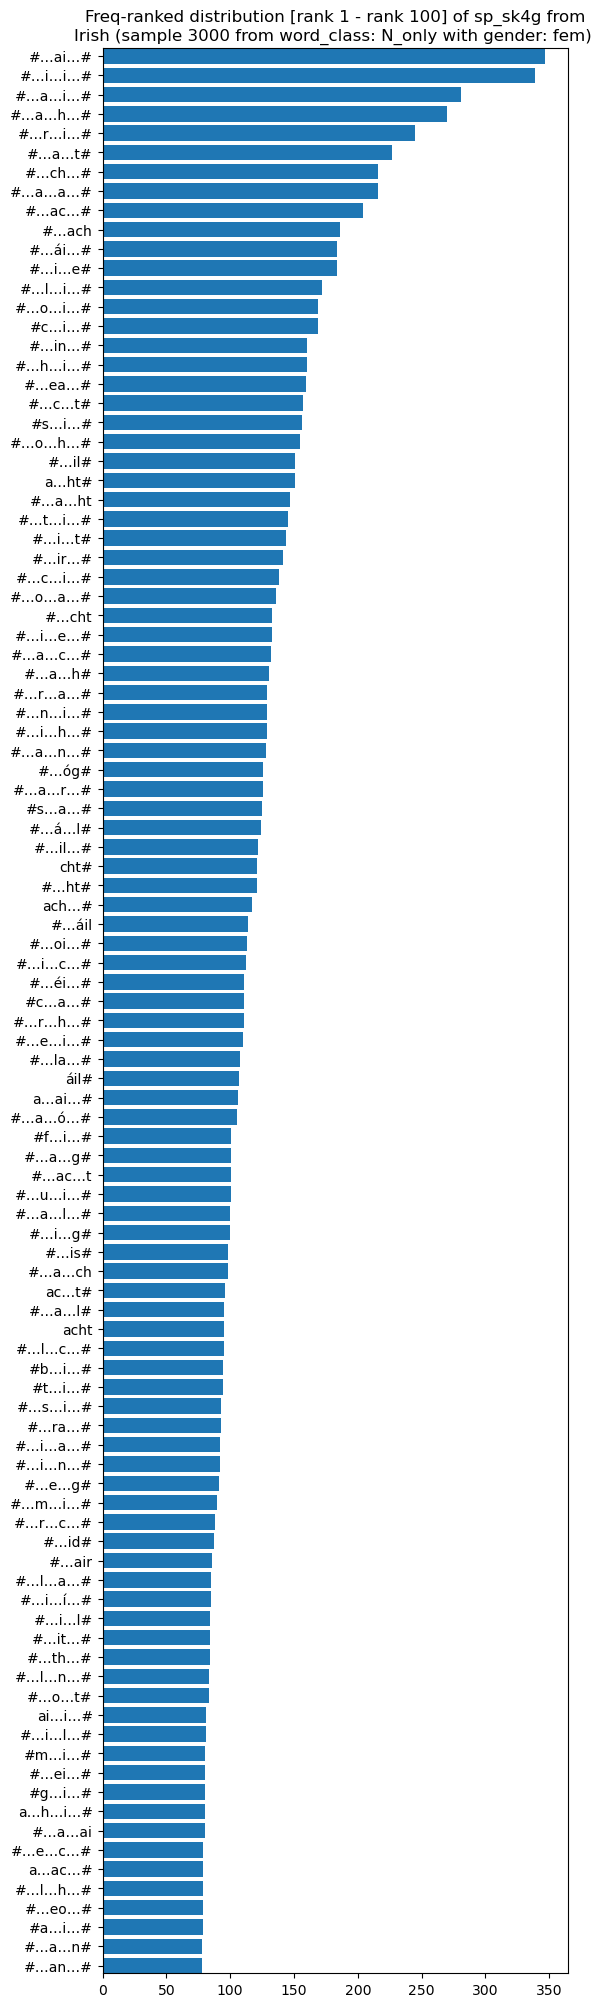

In [122]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [123]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk5gram
min_size: 1
supplement_var: sp_sk4gram
7328     [#coth, #cot…r, #cot…o, #cot…i, #cot…m, #cot…e...
21189    [#óirt, #óir…h, #óir…í, #óir…#, #ói…th, #ói…t…...
1026     [#anai, #ana…r, #ana…í, #ana…#, #an…ir, #an…i…...
3780     [#buan, #bua…t, #bua…o, #bua…n, #bua…n, #bua…#...
11092    [#fada, #fad…r, #fad…a, #fad…í, #fad…#, #fa…ar...
                               ...                        
28984    [#tiom, #tio…á, #tio…i, #tio…n, #tio…t, #tio…#...
23943    [#rúbó, #rúb…g, #rúb…#, #rú…óg, #rú…ó…#, #rú…g...
12648    [#fort, #for…a, #for…c, #for…h, #for…t, #for…#...
2911     [#bocá, #boc…i, #boc…l, #boc…#, #bo…ái, #bo…á…...
8103     [#cuin, #cui…n, #cui…e, #cui…o, #cui…g, #cui…#...
Name: sp_sk5gram, Length: 1656, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


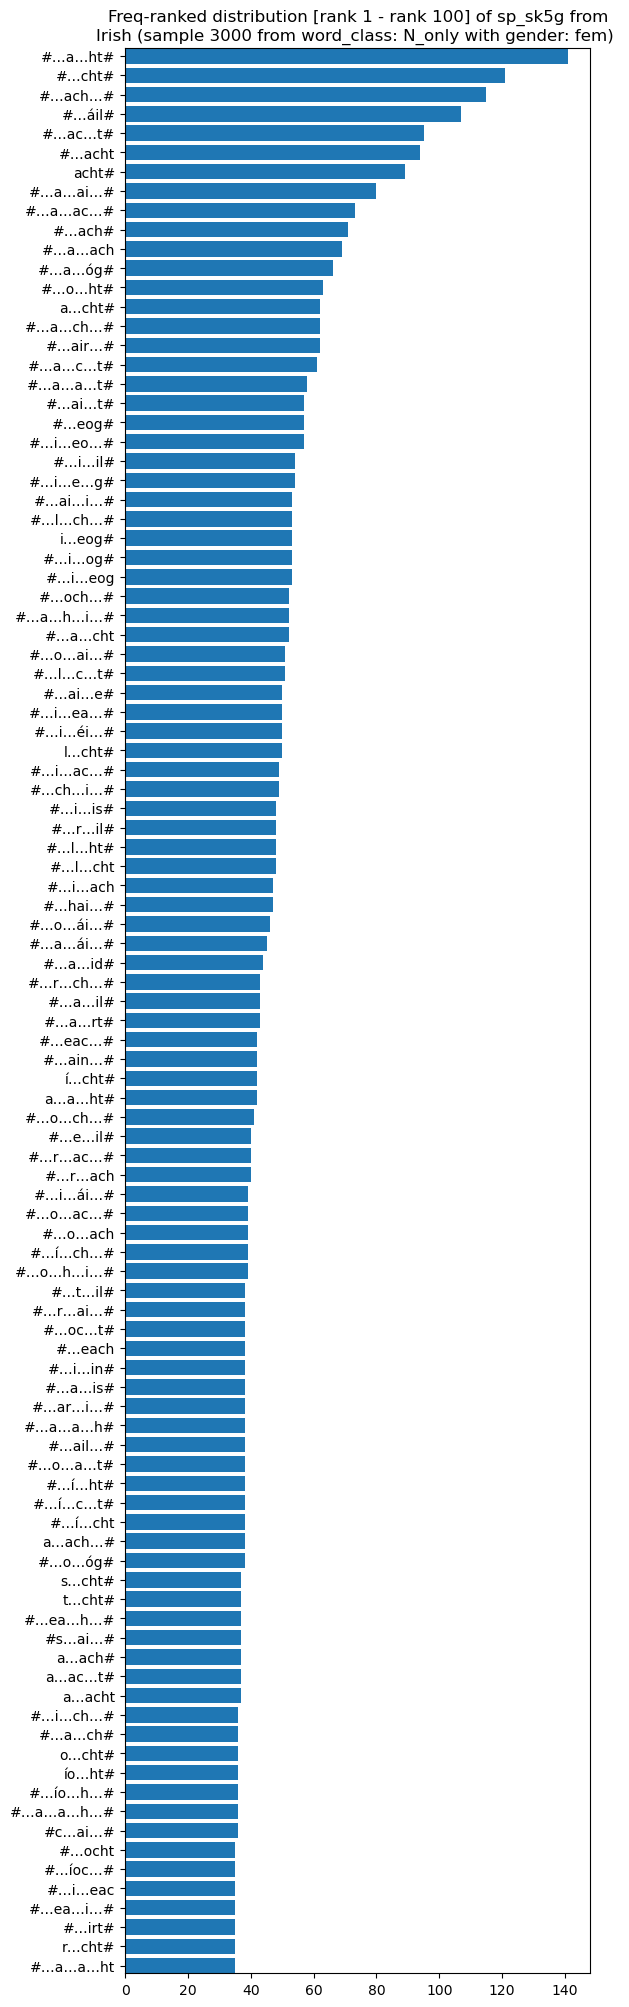

In [124]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

## Sound

In [125]:
## stop for unimplemented language
if target_lang_name in [ 'Irish' ]:
    import sys
    sys.exit()

SystemExit: 

/Users/kowk/anaconda3/envs/py3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Non-skippy sound

In [ ]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
450     [#f, fɫ, ɫu, uə, ən, nt, tɫ, ɫi, i#, #, f, ɫ, ...
457     [#f, fɔ, ɔɹ, ɹm, mo, oʊ, ʊs, st, t#, #, f, ɔ, ...
285                       [#d, di, ip, p#, #, d, i, p, #]
569     [#h, hə, əm, mb, bɫ, ɫi, i#, #, h, ə, m, b, ɫ,...
40          [#ə, əɡ, ɡe, eɪ, ɪn, n#, #, ə, ɡ, e, ɪ, n, #]
                              ...                        
442     [#f, fɪ, ɪs, sk, kə, əɫ, ɫi, i#, #, f, ɪ, s, k...
875     [#o, oʊ, ʊv, vɝ, ɝs, si, iz, z#, #, o, ʊ, v, ɝ...
892     [#p, pe, eɪ, ɪʃ, ʃə, ən, nt, tɫ, ɫi, i#, #, p,...
1095    [#s, sɫ, ɫɑ, ɑp, pə, əɫ, ɫi, i#, #, s, ɫ, ɑ, p...
754         [#m, mi, ik, kɫ, ɫi, i#, #, m, i, k, ɫ, i, #]
Name: sn_2gram, Length: 379, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


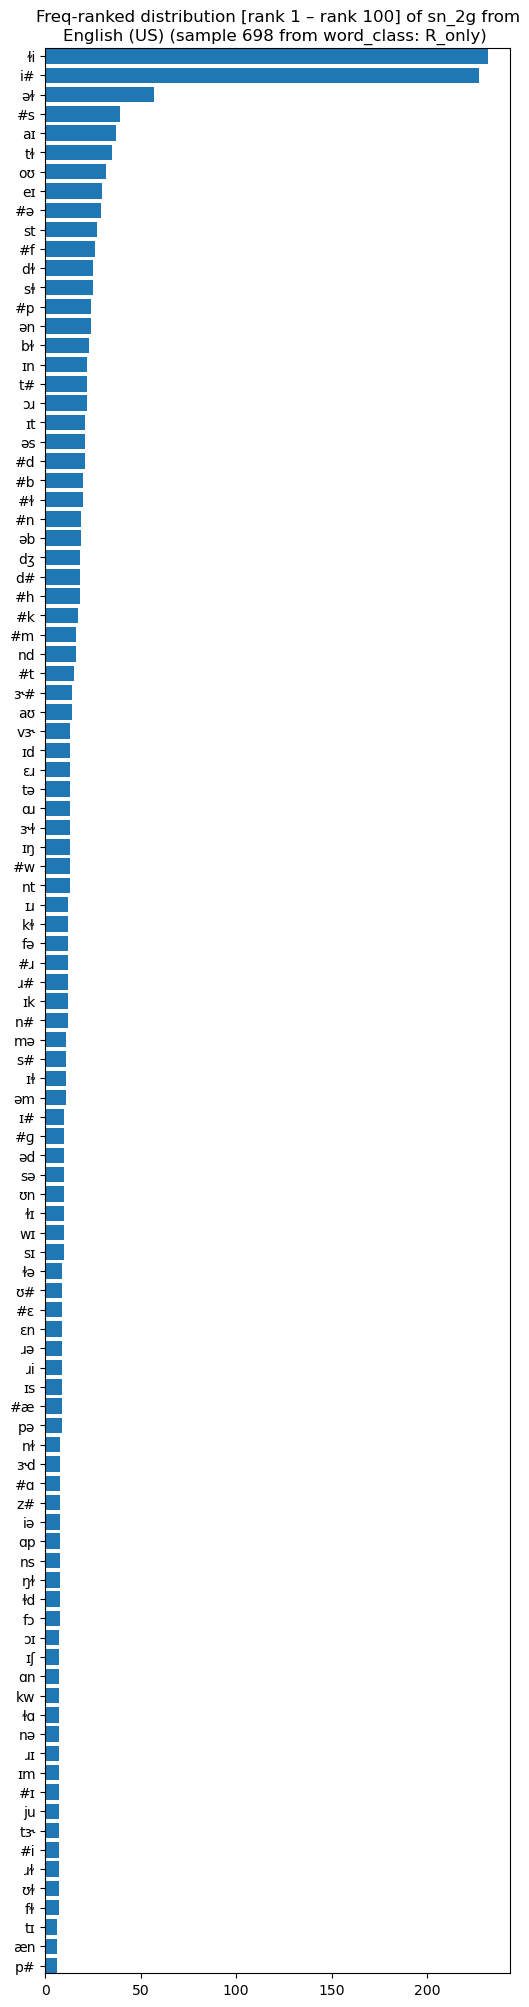

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
450     [#fɫ, fɫu, ɫuə, uən, ənt, ntɫ, tɫi, ɫi#, #f, f...
457     [#fɔ, fɔɹ, ɔɹm, ɹmo, moʊ, oʊs, ʊst, st#, #f, f...
285        [#di, dip, ip#, #d, di, ip, p#, #, d, i, p, #]
569     [#hə, həm, əmb, mbɫ, bɫi, ɫi#, #h, hə, əm, mb,...
40      [#əɡ, əɡe, ɡeɪ, eɪn, ɪn#, #ə, əɡ, ɡe, eɪ, ɪn, ...
                              ...                        
442     [#fɪ, fɪs, ɪsk, skə, kəɫ, əɫi, ɫi#, #f, fɪ, ɪs...
875     [#oʊ, oʊv, ʊvɝ, vɝs, ɝsi, siz, iz#, #o, oʊ, ʊv...
892     [#pe, peɪ, eɪʃ, ɪʃə, ʃən, ənt, ntɫ, tɫi, ɫi#, ...
1095    [#sɫ, sɫɑ, ɫɑp, ɑpə, pəɫ, əɫi, ɫi#, #s, sɫ, ɫɑ...
754     [#mi, mik, ikɫ, kɫi, ɫi#, #m, mi, ik, kɫ, ɫi, ...
Name: sn_3gram, Length: 379, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


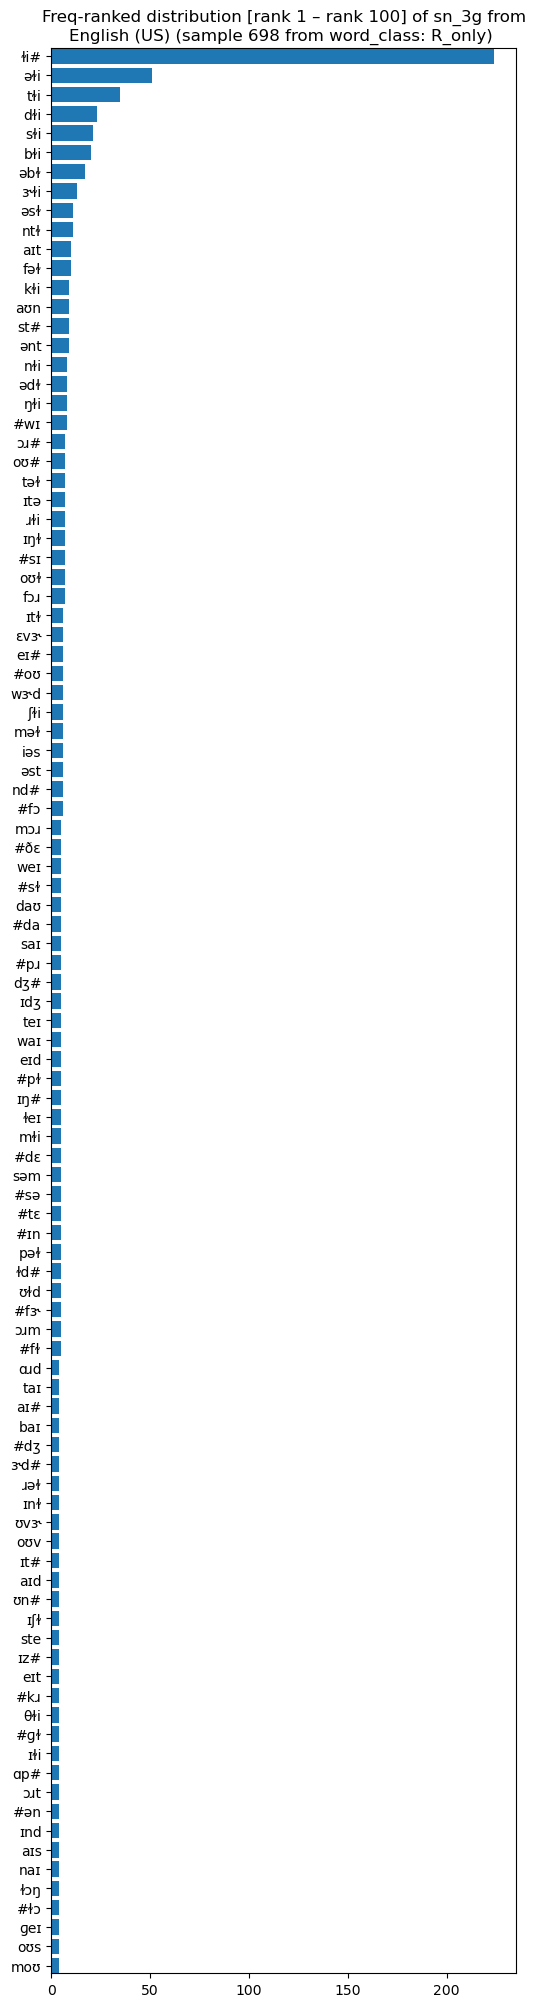

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
450     [#fɫu, fɫuə, ɫuən, uənt, əntɫ, ntɫi, tɫi#, #fɫ...
457     [#fɔɹ, fɔɹm, ɔɹmo, ɹmoʊ, moʊs, oʊst, ʊst#, #fɔ...
285     [#dip, dip#, #di, dip, ip#, #d, di, ip, p#, #,...
569     [#həm, həmb, əmbɫ, mbɫi, bɫi#, #hə, həm, əmb, ...
40      [#əɡe, əɡeɪ, ɡeɪn, eɪn#, #əɡ, əɡe, ɡeɪ, eɪn, ɪ...
                              ...                        
442     [#fɪs, fɪsk, ɪskə, skəɫ, kəɫi, əɫi#, #fɪ, fɪs,...
875     [#oʊv, oʊvɝ, ʊvɝs, vɝsi, ɝsiz, siz#, #oʊ, oʊv,...
892     [#peɪ, peɪʃ, eɪʃə, ɪʃən, ʃənt, əntɫ, ntɫi, tɫi...
1095    [#sɫɑ, sɫɑp, ɫɑpə, ɑpəɫ, pəɫi, əɫi#, #sɫ, sɫɑ,...
754     [#mik, mikɫ, ikɫi, kɫi#, #mi, mik, ikɫ, kɫi, ɫ...
Name: sn_4gram, Length: 379, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


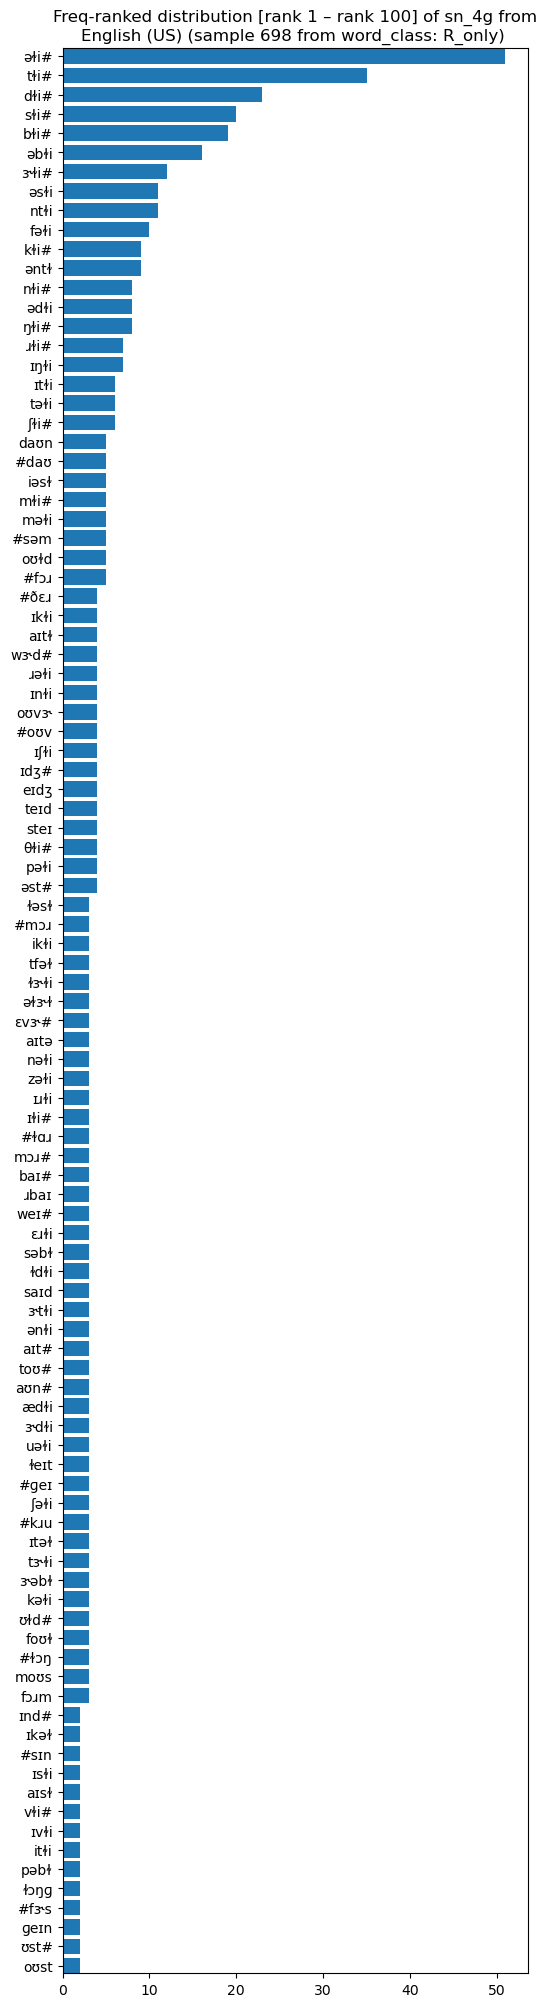

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
450     [#fɫuə, fɫuən, ɫuənt, uəntɫ, əntɫi, ntɫi#, #fɫ...
457     [#fɔɹm, fɔɹmo, ɔɹmoʊ, ɹmoʊs, moʊst, oʊst#, #fɔ...
285     [#dip#, #dip, dip#, #di, dip, ip#, #d, di, ip,...
569     [#həmb, həmbɫ, əmbɫi, mbɫi#, #həm, həmb, əmbɫ,...
40      [#əɡeɪ, əɡeɪn, ɡeɪn#, #əɡe, əɡeɪ, ɡeɪn, eɪn#, ...
                              ...                        
442     [#fɪsk, fɪskə, ɪskəɫ, skəɫi, kəɫi#, #fɪs, fɪsk...
875     [#oʊvɝ, oʊvɝs, ʊvɝsi, vɝsiz, ɝsiz#, #oʊv, oʊvɝ...
892     [#peɪʃ, peɪʃə, eɪʃən, ɪʃənt, ʃəntɫ, əntɫi, ntɫ...
1095    [#sɫɑp, sɫɑpə, ɫɑpəɫ, ɑpəɫi, pəɫi#, #sɫɑ, sɫɑp...
754     [#mikɫ, mikɫi, ikɫi#, #mik, mikɫ, ikɫi, kɫi#, ...
Name: sn_5gram, Length: 379, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


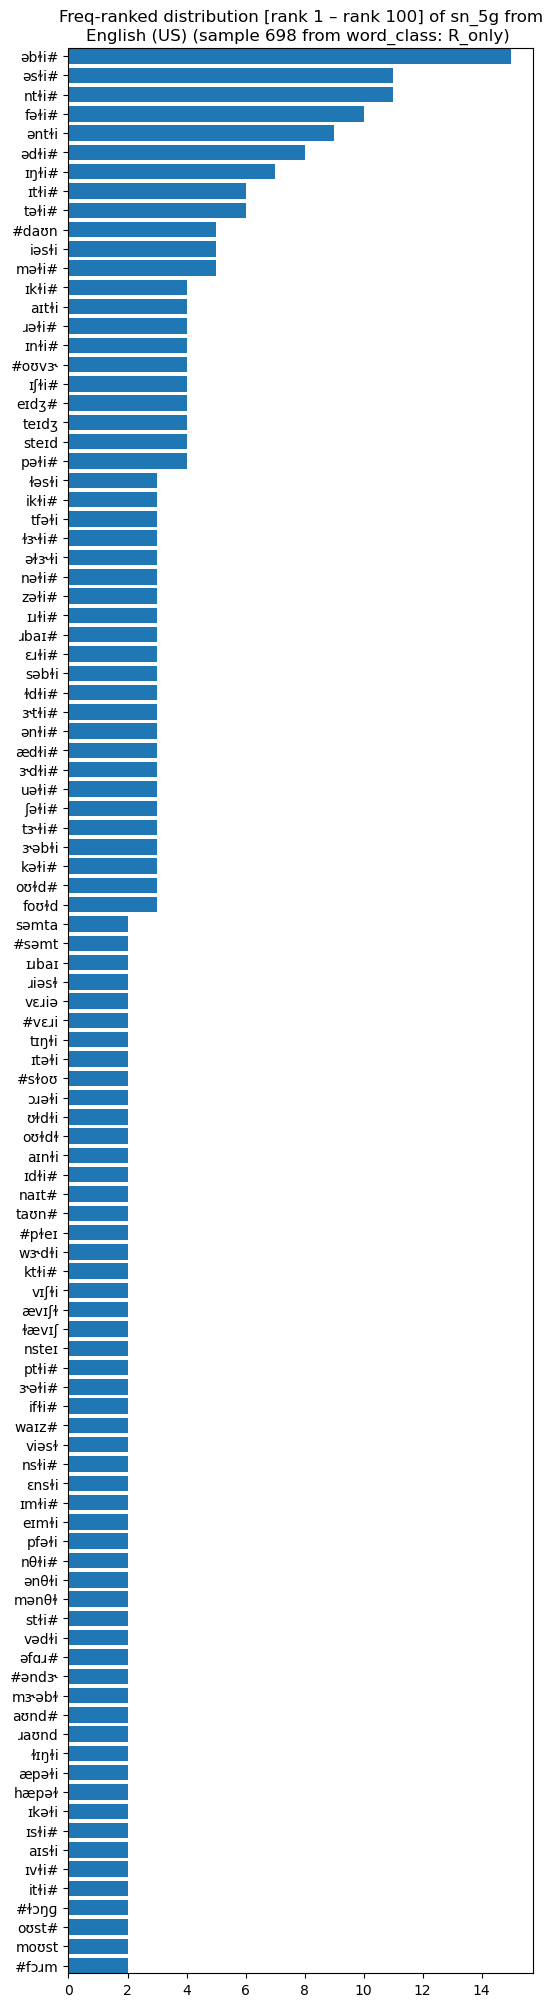

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy sound

In [ ]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk2gram
min_size: 1
supplement_var: sn_1gram
450     [#f, #…ɫ, #…u, #…ə, #…n, #…t, #…ɫ, #…i, #…#, f...
457     [#f, #…ɔ, #…ɹ, #…m, #…o, #…ʊ, #…s, #…t, #…#, f...
285     [#d, #…i, #…p, #…#, di, d…p, d…#, ip, i…#, p#,...
569     [#h, #…ə, #…m, #…b, #…ɫ, #…i, #…#, hə, h…m, h…...
40      [#ə, #…ɡ, #…e, #…ɪ, #…n, #…#, əɡ, ə…e, ə…ɪ, ə…...
                              ...                        
442     [#f, #…ɪ, #…s, #…k, #…ə, #…ɫ, #…i, #…#, fɪ, f…...
875     [#o, #…ʊ, #…v, #…ɝ, #…s, #…i, #…z, #…#, oʊ, o…...
892     [#p, #…e, #…ɪ, #…ʃ, #…ə, #…n, #…t, #…ɫ, #…i, #...
1095    [#s, #…ɫ, #…ɑ, #…p, #…ə, #…ɫ, #…i, #…#, sɫ, s…...
754     [#m, #…i, #…k, #…ɫ, #…i, #…#, mi, m…k, m…ɫ, m…...
Name: sn_sk2gram, Length: 379, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


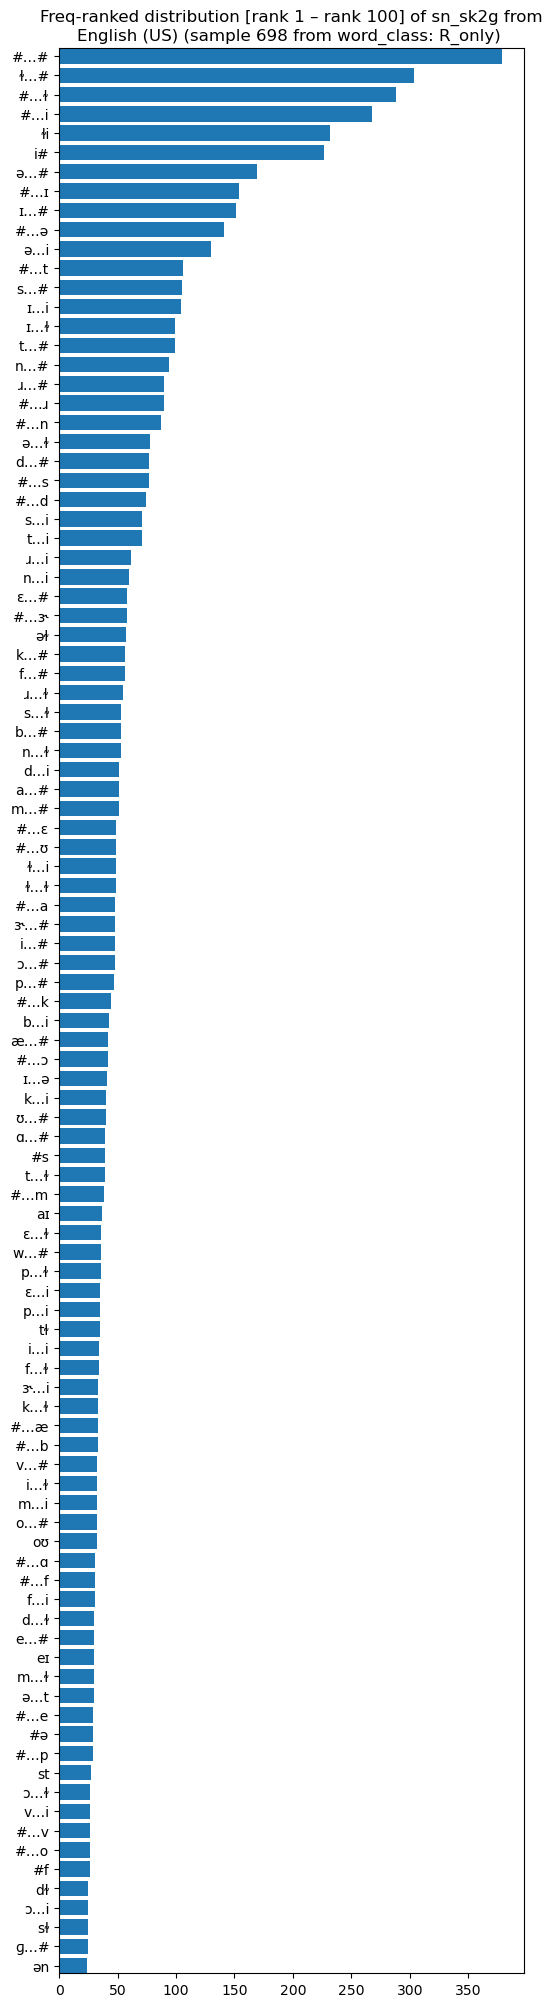

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk3gram
min_size: 1
supplement_var: sn_sk2gram
450     [#fɫ, #f…u, #f…ə, #f…n, #f…t, #f…ɫ, #f…i, #f…#...
457     [#fɔ, #f…ɹ, #f…m, #f…o, #f…ʊ, #f…s, #f…t, #f…#...
285     [#di, #d…p, #d…#, #…ip, #…i…#, #…p#, dip, di…#...
569     [#hə, #h…m, #h…b, #h…ɫ, #h…i, #h…#, #…əm, #…ə…...
40      [#əɡ, #ə…e, #ə…ɪ, #ə…n, #ə…#, #…ɡe, #…ɡ…ɪ, #…ɡ...
                              ...                        
442     [#fɪ, #f…s, #f…k, #f…ə, #f…ɫ, #f…i, #f…#, #…ɪs...
875     [#oʊ, #o…v, #o…ɝ, #o…s, #o…i, #o…z, #o…#, #…ʊv...
892     [#pe, #p…ɪ, #p…ʃ, #p…ə, #p…n, #p…t, #p…ɫ, #p…i...
1095    [#sɫ, #s…ɑ, #s…p, #s…ə, #s…ɫ, #s…i, #s…#, #…ɫɑ...
754     [#mi, #m…k, #m…ɫ, #m…i, #m…#, #…ik, #…i…ɫ, #…i...
Name: sn_sk3gram, Length: 379, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


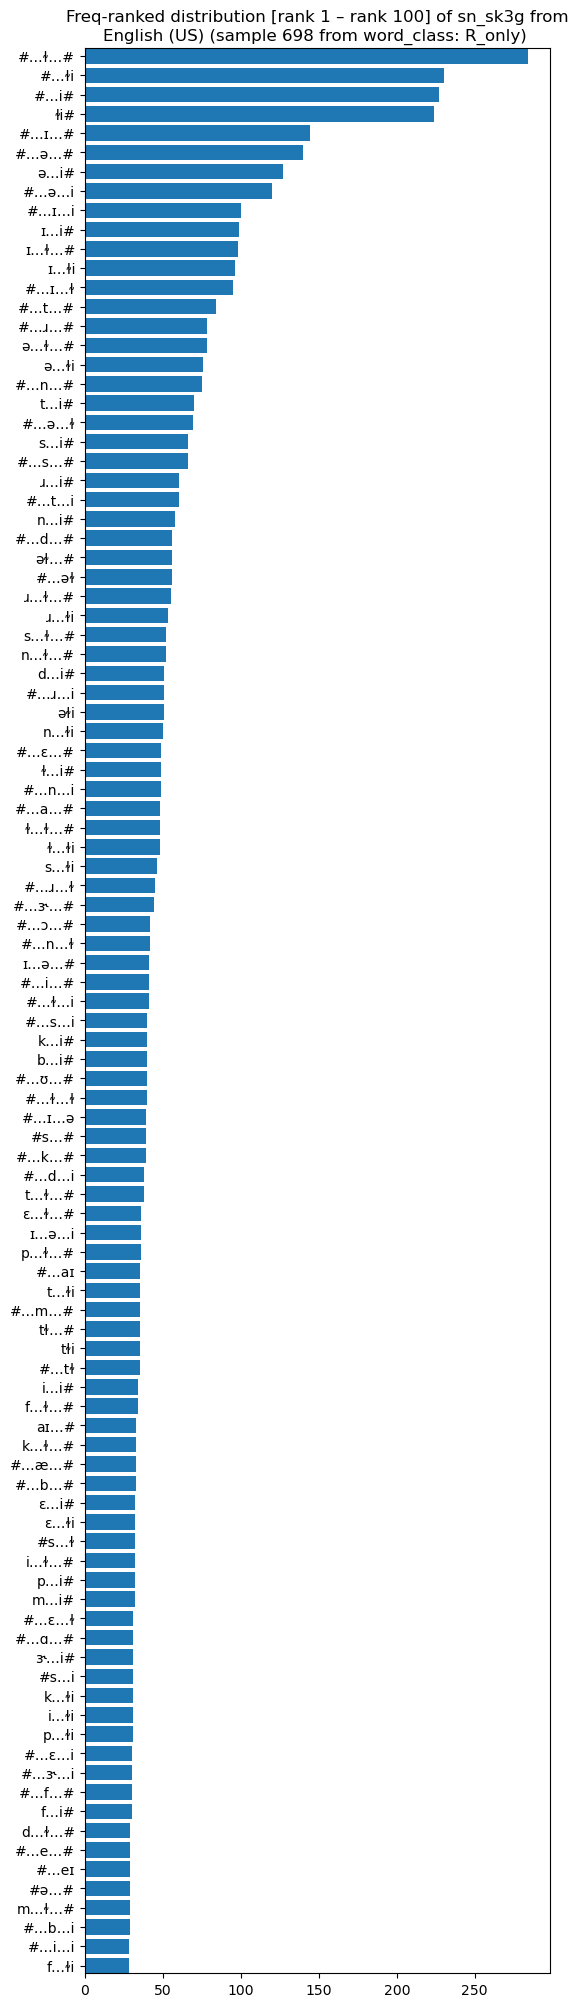

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk4gram
min_size: 1
supplement_var: sn_sk3gram
450     [#fɫu, #fɫ…ə, #fɫ…n, #fɫ…t, #fɫ…ɫ, #fɫ…i, #fɫ…...
457     [#fɔɹ, #fɔ…m, #fɔ…o, #fɔ…ʊ, #fɔ…s, #fɔ…t, #fɔ…...
285     [#dip, #di…#, #d…p#, #…ip#, dip#, #di, #d…p, #...
569     [#həm, #hə…b, #hə…ɫ, #hə…i, #hə…#, #h…mb, #h…m...
40      [#əɡe, #əɡ…ɪ, #əɡ…n, #əɡ…#, #ə…eɪ, #ə…e…n, #ə…...
                              ...                        
442     [#fɪs, #fɪ…k, #fɪ…ə, #fɪ…ɫ, #fɪ…i, #fɪ…#, #f…s...
875     [#oʊv, #oʊ…ɝ, #oʊ…s, #oʊ…i, #oʊ…z, #oʊ…#, #o…v...
892     [#peɪ, #pe…ʃ, #pe…ə, #pe…n, #pe…t, #pe…ɫ, #pe…...
1095    [#sɫɑ, #sɫ…p, #sɫ…ə, #sɫ…ɫ, #sɫ…i, #sɫ…#, #s…ɑ...
754     [#mik, #mi…ɫ, #mi…i, #mi…#, #m…kɫ, #m…k…i, #m…...
Name: sn_sk4gram, Length: 379, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


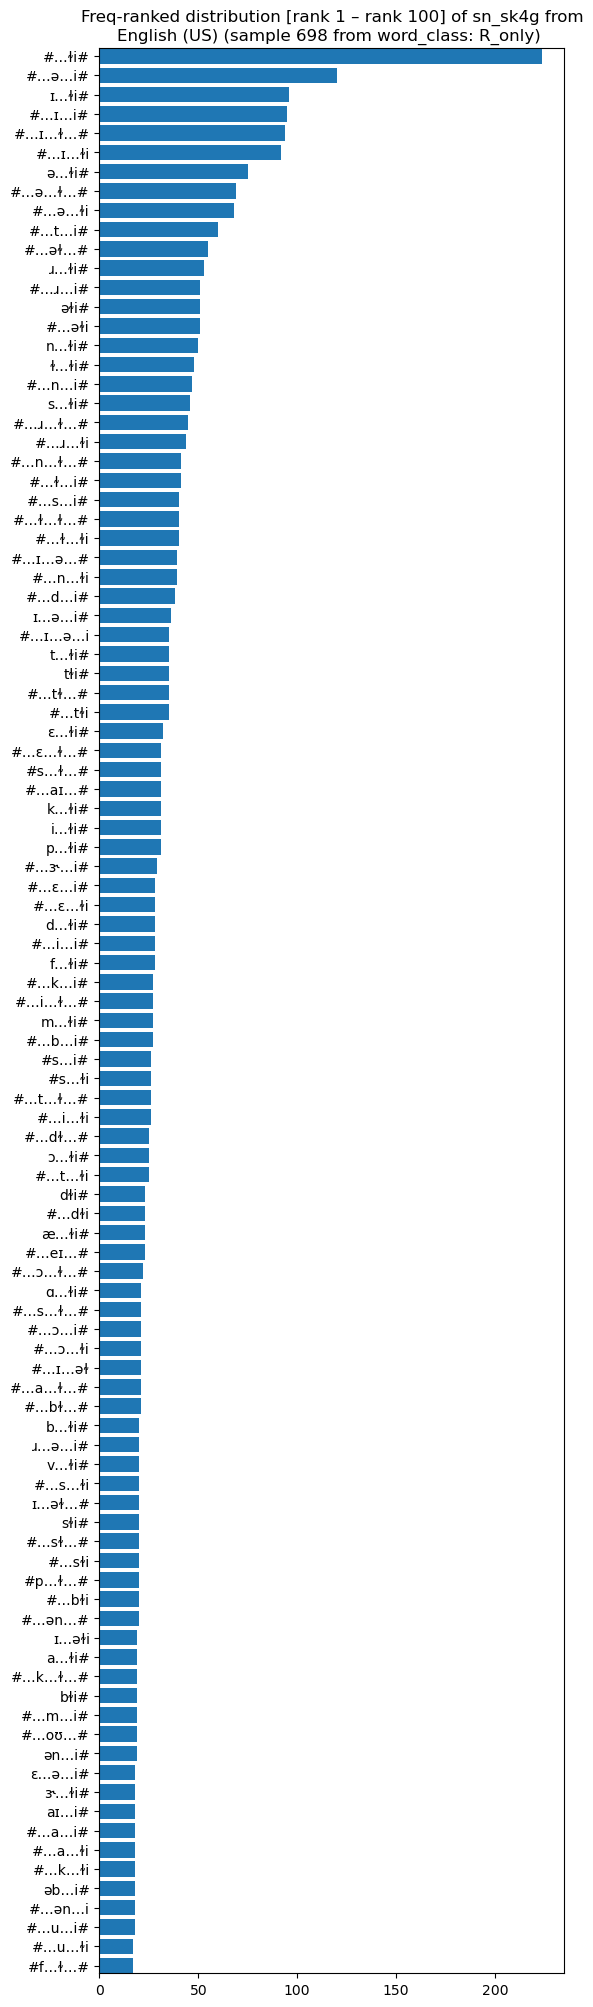

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk5gram
min_size: 1
supplement_var: sn_sk4gram
450     [#fɫuə, #fɫu…n, #fɫu…t, #fɫu…ɫ, #fɫu…i, #fɫu…#...
457     [#fɔɹm, #fɔɹ…o, #fɔɹ…ʊ, #fɔɹ…s, #fɔɹ…t, #fɔɹ…#...
285     [#dip#, #dip, #di…#, #d…p#, #…ip#, dip#, #di, ...
569     [#həmb, #həm…ɫ, #həm…i, #həm…#, #hə…bɫ, #hə…b…...
40      [#əɡeɪ, #əɡe…n, #əɡe…#, #əɡ…ɪn, #əɡ…ɪ…#, #əɡ…n...
                              ...                        
442     [#fɪsk, #fɪs…ə, #fɪs…ɫ, #fɪs…i, #fɪs…#, #fɪ…kə...
875     [#oʊvɝ, #oʊv…s, #oʊv…i, #oʊv…z, #oʊv…#, #oʊ…ɝs...
892     [#peɪʃ, #peɪ…ə, #peɪ…n, #peɪ…t, #peɪ…ɫ, #peɪ…i...
1095    [#sɫɑp, #sɫɑ…ə, #sɫɑ…ɫ, #sɫɑ…i, #sɫɑ…#, #sɫ…pə...
754     [#mikɫ, #mik…i, #mik…#, #mi…ɫi, #mi…ɫ…#, #mi…i...
Name: sn_sk5gram, Length: 379, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25599/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


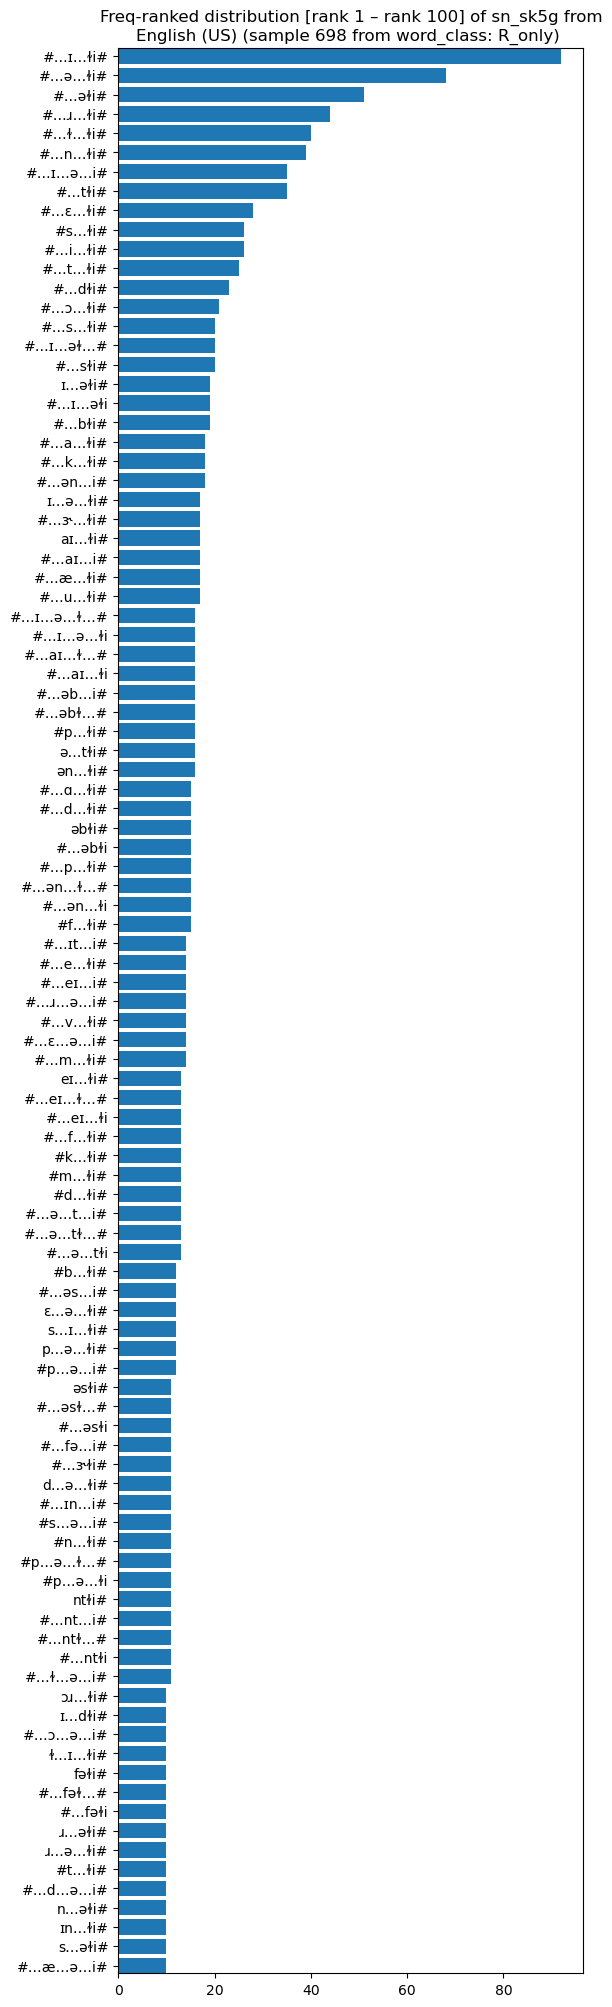

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

# End